# **Neural Machine Translation**

This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for Spanish-to-English translation using [Transformer](https://arxiv.org/abs/1706.03762)

In [ ]:
%%capture
!pip install "tensorflow-text>=2.11"

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow_text as tf_text
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [ ]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [ ]:
# reading the data
def load_data(path):
  # reading the data
  text = path.read_text(encoding='utf-8')
  lines = text.splitlines()

  # splitting the data (source and target) by the separator tab
  pairs = [line.split('\t') for line in lines]

  # context and target arrays
  context = np.array([context for target, context in pairs])
  target = np.array([target for target, context in pairs])

  return context, target 

context_raw, target_raw = load_data(path_to_file)
print("Number of Samples: ",len(context_raw))

Number of Samples:  118964


In [ ]:
context_raw[-1]

'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.'

In [ ]:
target_raw[-1]

'If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.'

In [ ]:
# Creating a tf.data dataset of the strings that shuffles and batches
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))
val_raw = (tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

In [ ]:
for sp_examples, en_examples in train_raw.take(1):
  print('> Examples in Spanish:')
  for sp in sp_examples[:5]:
    print(sp.numpy().decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples[:5]:
    print(en.numpy().decode('utf-8'))

> Examples in Spanish:
Dije eso, pero no lo dije en serio.
Ella hizo un viaje a Europa el mes pasado.
No podemos confiarle algo así a Tom.
Yo puedo hacer eso.
Mis vecinos son amigos míos.

> Examples in English:
I did say that, but I didn't mean it.
She made a trip to Europe last month.
We can't trust Tom with something like this.
I can do that.
My neighbors are my friends.


In [ ]:
# standardizing and processing the text
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)
  # prepend and append START and END tokens to each sentence in the context and target
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [ ]:
max_vocab_size = 7000

# the Spanish TextVectorization
context_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size, ragged=True)
# This adapt method initializes the layer based on the data.
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# The first 10 words from context the vocabulary
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [ ]:
# the English TextVectorization
target_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size, ragged=True)
# This adapt method initializes the layer based on the data.
target_text_processor.adapt(train_raw.map(lambda context, target: target))

# The first 10 words from target the vocabulary
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [ ]:
example_tokens = context_text_processor(sp_examples)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 324, 43, 19, 94, 9, 22, 324, 14, 925, 4, 3],
 [2, 29, 128, 16, 552, 8, 1165, 7, 375, 178, 4, 3],
 [2, 9, 300, 1, 57, 164, 8, 10, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] dije eso , pero no lo dije en serio . [END]'

In [ ]:
# The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs.
# It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit.
# The difference between target_in and target_out is that they are shifted by one step relative to eachother,
# so that at each location the label is the next token.
def process_text(context, target):
  # convert the context strings to 0-padded tensors of token IDs.
  context = context_text_processor(context).to_tensor()
  # convert the target strings to ragged tensors of token IDs.
  target = target_text_processor(target)
  # 0-padded target tensors of token IDs except the last token
  targ_in = target[:,:-1].to_tensor()
  # 0-padded target tensors of token IDs shifted by one step relative to targ_in
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (context_tokens, target_tokens_in), target_tokens_out in train_ds.take(1):
  print(context_tokens[0].numpy()) 
  print()
  print(target_tokens_in[0].numpy()) 
  print(target_tokens_out[0].numpy())

[   2   29   22 5288   31    5    1    4    3    0    0    0    0    0
    0    0    0]

[   2   26 5706   44    7  672    4    0    0    0    0    0    0]
[  26 5706   44    7  672    4    3    0    0    0    0    0    0]


In [ ]:
for (sp, en), en_labels in train_ds.take(1):
  break

print(sp.shape)
print(en.shape)
print(en_labels.shape)

(64, 16)
(64, 15)
(64, 15)


### Defining the components

![](https://github.com/MarwanMohamed95/Neural-Machine-Translation-with-Transformer/blob/main/transformer.png?raw=true)

#### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$
\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model} })} \\
\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model} })}
$$

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

So we use this to create a PositionEmbedding layer that looks-up a token's embedding vector and adds the position vector:

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_sp = PositionalEmbedding(vocab_size=context_text_processor.vocabulary_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=target_text_processor.vocabulary_size(), d_model=512)

sp_emb = embed_sp(sp)
en_emb = embed_en(en)

#### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a layers.MultiHeadAttention, a  layers.LayerNormalization and a layers.Add.

The BaseAttention class is a base class that just contains the component layers. Each use-case will be implemented as a subclass.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### The cross attention layer

This layer connects the encoder and decoder

$$
\begin{aligned}
\text{Attention}(Q, K, V) &= \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
\end{aligned}
$$

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(sp_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, sp_emb).shape)

(64, 16, 512)
(64, 15, 512)
(64, 15, 512)


#### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length.
The global self attention layer lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(sp_emb.shape)
print(sample_gsa(sp_emb).shape)

(64, 16, 512)
(64, 16, 512)


#### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence.
This needs to be handled differently from the encoder's global self attention layer.
Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".
To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention values.

This is taken care of automatically if you pass use_causal_mask = True to the MultiHeadAttention layer when we call it.

The causal mask ensures that each location only has access to the locations that come before it

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 15, 512)
(64, 15, 512)


In [ ]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

#### The feed forward network

The transformer includes feed-forward network in both the encoder and decoder

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 15, 512)
(64, 15, 512)


#### The encoder layer

The encoder contains a stack of N encoder layers. Where each EncoderLayer contains a GlobalSelfAttention and FeedForward layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(sp_emb.shape)
print(sample_encoder_layer(sp_emb).shape)

(64, 16, 512)
(64, 16, 512)


#### The encoder

The encoder consists of:

- A PositionalEmbedding layer at the input.
- A stack of EncoderLayer layers.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=max_vocab_size)

sample_encoder_output = sample_encoder(sp, training=False)

# Print the shape.
print(sp.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 16)
(64, 16, 512)


#### The decoder layer

The decoder's layer consists of DecoderLayer containing a CausalSelfAttention, a CrossAttention, and a FeedForward layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=sp_emb)

print(en_emb.shape)
print(sp_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 15, 512)
(64, 16, 512)
(64, 15, 512)


#### The decoder
Similar to the Encoder, the Decoder consists of a PositionalEmbedding, and a stack of DecoderLayers

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=max_vocab_size)

output = sample_decoder(x=en, context=sp_emb)

# Print the shapes.
print(en.shape)
print(sp_emb.shape)
print(output.shape)

(64, 15)
(64, 16, 512)
(64, 15, 512)


#### The Transformer
We now have Encoder and Decoder. To complete the Transformer model, we need to put them together and add a final linear (Dense) layer which converts the resulting vector at each location into output token probabilities.

The output of the decoder is the input to this final linear layer.

A Transformer with one layer in both the Encoder and Decoder looks almost exactly like the model from the RNN+attention tutorial. A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
# Model parameters in original paper
# num_layers = 6
# d_model = 512
# dff = 2048
# num_heads = 8
# dropout_rate = 0.1

# parameters used in this code
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=context_text_processor.vocabulary_size(),
    target_vocab_size=target_text_processor.vocabulary_size(),
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((sp, en))

print(en.shape)
print(sp.shape)
print(output.shape)

(64, 15)
(64, 16)
(64, 15, 7000)


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 15, 16)


In [ ]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  3534848   
                                                                 
 decoder_3 (Decoder)         multiple                  5645824   
                                                                 
 dense_77 (Dense)            multiple                  903000    
                                                                 
Total params: 10,083,672
Trainable params: 10,083,672
Non-trainable params: 0
_________________________________________________________________


### Training

Optimizer:

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.

$$
\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}
$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

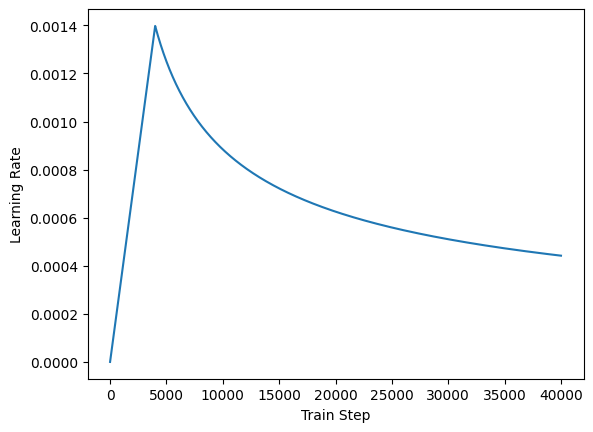

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

#### Defining Loss and Accuracy functions

Applying a padding mask when calculating the loss because the target sequences are padded.

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

In [ ]:
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])

In [ ]:
# model evaluation before training
transformer.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 51ms/step - loss: 8.8605 - masked_accuracy: 0.0000e+00


{'loss': 8.860487937927246, 'masked_accuracy': 0.0}

In [ ]:
history = transformer.fit(train_ds, epochs=30, validation_data=val_ds, callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/30
1487/1487 [==============================] - 180s 92ms/step - loss: 4.7402 - masked_accuracy: 0.3631 - val_loss: 2.7069 - val_masked_accuracy: 0.5509
Epoch 2/30
1487/1487 [==============================] - 125s 84ms/step - loss: 2.2596 - masked_accuracy: 0.6161 - val_loss: 1.7670 - val_masked_accuracy: 0.6861
Epoch 3/30
1487/1487 [==============================] - 124s 83ms/step - loss: 1.7218 - masked_accuracy: 0.6870 - val_loss: 1.5051 - val_masked_accuracy: 0.7211
Epoch 4/30
1487/1487 [==============================] - 124s 83ms/step - loss: 1.4210 - masked_accuracy: 0.7309 - val_loss: 1.3068 - val_masked_accuracy: 0.7533
Epoch 5/30
1487/1487 [==============================] - 123s 83ms/step - loss: 1.2308 - masked_accuracy: 0.7609 - val_loss: 1.2067 - val_masked_accuracy: 0.7701
Epoch 6/30
1487/1487 [==============================] - 123s 83ms/step - loss: 1.1133 - masked_accuracy: 0.7800 - val_loss: 1.1540 - val_masked_accuracy: 0.7789
Epoch 7/30
1487/1487 [============

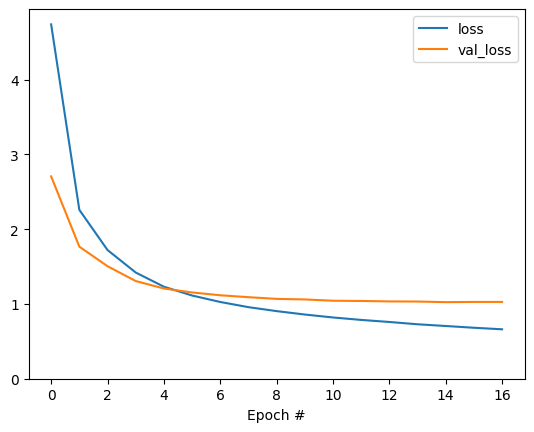

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.legend()
plt.show()

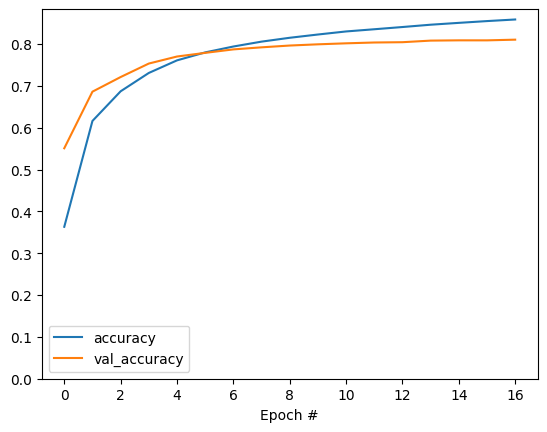

In [ ]:
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.legend()
plt.show()

In [ ]:
# model evaluation before training
transformer.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 1s 52ms/step - loss: 1.0422 - masked_accuracy: 0.8053


{'loss': 1.042173981666565, 'masked_accuracy': 0.8052743077278137}

### Inference

In [ ]:
class Translator(tf.Module):
  def __init__(self, target_text_processor, context_text_processor, transformer):
    self.transformer = transformer
    # target text processor
    self.target_text_processor = target_text_processor
    self.context_text_processor = context_text_processor
    self.vocab_size = self.target_text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(vocabulary = self.target_text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(vocabulary = self.target_text_processor.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)
    self.start_token = self.word_to_id('[START]')[tf.newaxis]
    self.end_token = self.word_to_id('[END]')[tf.newaxis]

  
  def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result
    
  def __call__(self, sentence, max_length=128):
    # The input sentence is Spanish, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    # tokenizing the sentence and converting it ti tokens ID
    sentence = self.context_text_processor(sentence).to_tensor()

    encoder_input = sentence

    # output_array which will hold the predicted tokens ID
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, self.start_token)

    for i in tf.range(max_length):
      # getting the predicted tokens so far
      output = tf.transpose(output_array.stack())
      # getting the new prediction
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == self.end_token:
        break

    output = tf.transpose(output_array.stack())
    result = self.tokens_to_text(output)[0]

    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return result, attention_weights

In [ ]:
translator = Translator(target_text_processor, context_text_processor, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = '¿Todavía está en casa?'
ground_truth = 'Are you still home.'

translated_text, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : ¿Todavía está en casa?
Prediction     : is he at home yet ?
Ground truth   : Are you still home.


In [ ]:
sentence = 'Hace mucho frio aqui.'
ground_truth = "It's really cold here."

translated_text, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Hace mucho frio aqui.
Prediction     : its very cold here .
Ground truth   : It's really cold here.


In [ ]:
sentence = 'Esta es mi vida.'
ground_truth = "This is my life."

translated_text, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Esta es mi vida.
Prediction     : this is my life .
Ground truth   : This is my life.


In [ ]:
sentence = 'Su cuarto es un desastre.'
ground_truth = "His room is a mess"

translated_text, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Su cuarto es un desastre.
Prediction     : his room is a mess .
Ground truth   : His room is a mess


In [ ]:
sentence = context_raw[-1]
ground_truth = target_raw[-1]

translated_text, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
Prediction     : if you want to sound like a native speaker , you must be willing to practice over and over the same sentence over .
Ground truth   : If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Saving the model

In [ ]:
class Export(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, attention_weights) = self.translator(sentence, max_length=128)

    return result

In [ ]:
export = Export(translator)

In [ ]:
tf.saved_model.save(export, export_dir='translator')

In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this and [UNK] will be found by [UNK] .'

In [ ]:
sentence = "¿Todavía está en casa?"
ground_truth = 'Are you still home.'

translated_text = reloaded(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : ¿Todavía está en casa?
Prediction     : is he at home yet ?
Ground truth   : Are you still home.
